# Creating spatial index for ascii clusters

**Original code:** [Alexandros Korkovelos](https://github.com/akorkovelos) <br />

**In this notebook, we use ascii files (or derivatives) in order to assign spatial index to CLEWs clusters.** 

In brief, the process has as follows:

- First, we import a sample ascii grid file using rasterio and convert it into a tif. 
- Then we use a bundle of functions to parse the tif in the form of an array, and use gdal to convert the array to a point vector. Together with the coordinates for each vector point, we extract the equivalent row/col index from the initial file. This allows to create an "id" which can be used as a merger attribute with data that do not have spatial index (e.g. CLEWs clusters). 
- After merging and cleaning the notebook yields a vector layer with the spatial resolution of the input ascii layer and information of the additional layers.

The output layer creates the base for further spatially explicit information extraction!

## Import necessary modules 

In [8]:
# Importing modules

# Numerical
import numpy as np
import pandas as pd
import math
from math import *

# Spatial
import geopandas as gpd
import rasterio
from shapely.geometry import Polygon, Point
from shapely.ops import nearest_points
import ogr, gdal, osr
from pyproj import CRS

# System & Other
import os

#Plotting
import matplotlib.pyplot as plt
%matplotlib inline

## Provide paths and file names

In [9]:
# Directories
ROOT_DIR = os.path.abspath(os.curdir)
in_path = os.path.join(ROOT_DIR, 'sample_input')
out_path = os.path.join(ROOT_DIR, 'sample_output')

# ascii file name
asci_nm = 'data.asc'

# administrative boundaries of the AoI
admin_nm = 'eth_adm0.gpkg'

# raster name
raster_nm = "data.tif"

# vector point name
shp_nm = "data.shp"

# CLEWs cluster name
clust_nm = "ethiopia_clusters.csv"

# Final shp product layer
out_nm = "Ethiopia_vector_clusters" 

### Define projection systems to be used

In [10]:
# Originan WGS84 coordinate system
crs_WGS84 = CRS("EPSG:4326")

# Projection system for Ethiopia see http://epsg.io/ for more info
crs_proj_ETH = CRS("EPSG:32637")

## Step 1. Provide spatial index to the tabular cluster data

### Open an ascii grid file | re-write as tif

This is a pre-requisite step if one starts with an ascii base grid. The step can be omitted if the base grid is already a tiff

In [11]:
# Import ascii and export as tif

with rasterio.open(in_path + '\\' + asci_nm) as src:
    data = src.read(1)                  # The number defined the band, not that changing data might require change of band

    #Export ascii as tif for easier processing
    with rasterio.open(out_path +"\\" + raster_nm, 
                       'w', 
                       driver='GTiff', 
                       height=data.shape[0], 
                       width=data.shape[1], 
                       count=data.shape[1],
                       dtype=data.dtype,
                       crs=src.crs,
                       transform=src.transform) as dst:
        dst.write(data, 3) 
        
resolution = src.res[0]

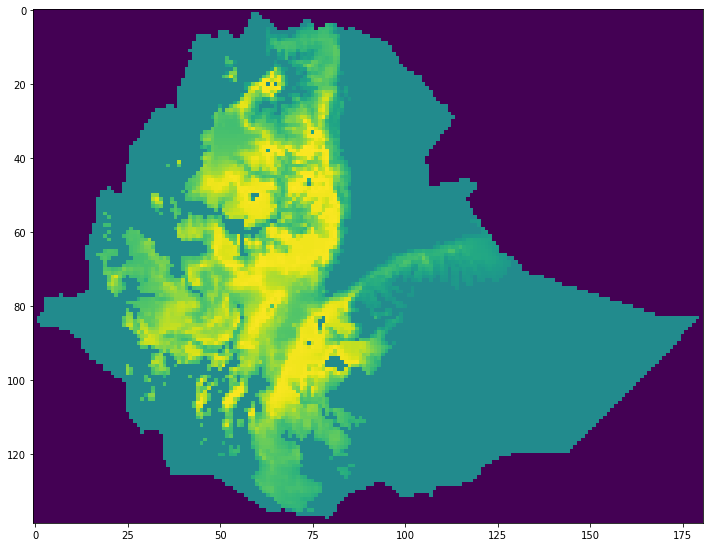

In [12]:
plt.figure(figsize = (12,12))
plt.imshow(data, cmap='viridis')
plt.show()

**Note!**

Rasterio imports raster files as 2-d arrays. The dimensions of the array are related to the spatial resolution of the imported layer. Individual values can be access in common practice as in numpy arrays. 

### Import tif and transform it to point vector

In [13]:
# Define functions

def pixelOffset2coord(raster, xOffset,yOffset):
    geotransform = raster.GetGeoTransform()
    originX = geotransform[0]+(geotransform[1]/2)     # this is to get the center of each pixel; remove all after + for getting the corners of the pixel
    originY = geotransform[3]+(geotransform[5]/2)     # this is to get the center of each pixel; remove all after + for getting the corners of the pixel
    pixelWidth = geotransform[1]
    pixelHeight = geotransform[5]
    coordX = originX+pixelWidth*xOffset
    coordY = originY+pixelHeight*yOffset
    return coordX, coordY

def raster2array(rasterfn, band_no):
    raster = gdal.Open(rasterfn)
    band = raster.GetRasterBand(band_no)    # Be aware of the band you need here
    array = band.ReadAsArray()
    return array

def array2shp(array,outSHPfn,rasterfn):

    # max distance between points
    raster = gdal.Open(rasterfn)
    geotransform = raster.GetGeoTransform()
    pixelWidth = geotransform[1]

    srs = osr.SpatialReference()
    srs.ImportFromWkt(raster.GetProjection())
    
    # wkbPoint
    shpDriver = ogr.GetDriverByName("ESRI Shapefile")
    if os.path.exists(outSHPfn):
        shpDriver.DeleteDataSource(outSHPfn)
    outDataSource = shpDriver.CreateDataSource(outSHPfn)
    outLayer = outDataSource.CreateLayer(outSHPfn, geom_type=ogr.wkbPoint, srs=srs )
    featureDefn = outLayer.GetLayerDefn()
    outLayer.CreateField(ogr.FieldDefn("VALUE", ogr.OFTString))

    # array2dict
    point = ogr.Geometry(ogr.wkbPoint)
    row_count = array.shape[0]
    for ridx, row in enumerate(array):
        if ridx % 10 == 0:
            print ("{0} of {1} rows processed".format(ridx, row_count))
        for cidx, value in enumerate(row):
            index = str(ridx) + "_" + str(cidx)
            Xcoord, Ycoord = pixelOffset2coord(raster,cidx,ridx)
            point.AddPoint(Xcoord, Ycoord)
            # Create the feature and set values
            outFeature = ogr.Feature(featureDefn)
            outFeature.SetGeometry(point)
            outFeature.SetField("VALUE", str(index))
            outLayer.CreateFeature(outFeature)
            outFeature.Destroy()
            #outDS.Destroy()
    print ("\nProcess completed!")

def main(rasterfn,outSHPfn, band_no):
    array = raster2array(rasterfn, band_no)
    array2shp(array,outSHPfn,rasterfn)

In [14]:
# Provide the input raster and give a name to the output transformed vector
raster = out_path + "\\" + raster_nm
outSHP = out_path + "\\" + shp_nm

# Run the function
main(raster,outSHP, band_no=3)

0 of 139 rows processed
10 of 139 rows processed
20 of 139 rows processed
30 of 139 rows processed
40 of 139 rows processed
50 of 139 rows processed
60 of 139 rows processed
70 of 139 rows processed
80 of 139 rows processed
90 of 139 rows processed
100 of 139 rows processed
110 of 139 rows processed
120 of 139 rows processed
130 of 139 rows processed

Process completed!


### Import vector point layer into a geo-dataframe

In [15]:
# Create a new geo-dataframe
data_gdf = gpd.read_file(out_path + "\\" + shp_nm)

In [16]:
data_gdf.head(3)

,VALUE,geometry
0,0_0,POINT (32.95833 14.87500)
1,0_1,POINT (33.04167 14.87500)
2,0_2,POINT (33.12500 14.87500)


**Note!**

VALUE has been retrieved from the ascii file; it denotes the number of row and column in the initial layer, split by the underscore delimiter.

#### Split VALUE and create two separate columns for [row] and [col]

In [17]:
# Split the Value to rows and columns
split = data_gdf["VALUE"].str.split("_", n = 1, expand = True)

In [18]:
# Drop the VALUE as it has served its purpose
data_gdf = data_gdf.drop(["VALUE"], axis=1)

In [19]:
# Add the separate columns back to the dataframe
data_gdf["row"] = split[0]
data_gdf["col"] = split[1]

In [20]:
# Change dtype of columns from str to int
data_gdf["row"] = data_gdf["row"].astype(np.int)
data_gdf["col"] = data_gdf["col"].astype(np.int)

In [21]:
# Create a tuple id to use for merging later on
data_gdf["id"] = list(zip(data_gdf.row, data_gdf.col))

In [22]:
data_gdf.head(3)

,geometry,row,col,id
0,POINT (32.95833 14.87500),0,0,"(0, 0)"
1,POINT (33.04167 14.87500),0,1,"(0, 1)"
2,POINT (33.12500 14.87500),0,2,"(0, 2)"


In [23]:
data_gdf.describe()

,row,col
count,25159.000000,25159.00000
mean,69.000000,90.00000
std,40.125603,52.25044
min,0.000000,0.00000
25%,34.000000,45.00000
50%,69.000000,90.00000
75%,104.000000,135.00000
max,138.000000,180.00000


### Import CLEWs cluster tabular data into a dataframe

In [24]:
# Import csv as pandas dataframe
cluster_data = pd.read_csv(in_path + "\\" + clust_nm)

In [25]:
cluster_data.head(3)

,row,col,cluster
0,1,59,TIGC02
1,1,60,TIGC02
2,2,59,TIGC02


In [26]:
# Create a tuple id to be used for merging
cluster_data['id'] = list(zip(cluster_data.row, cluster_data.col))

In [27]:
cluster_data.head(3)

,row,col,cluster,id
0,1,59,TIGC02,"(1, 59)"
1,1,60,TIGC02,"(1, 60)"
2,2,59,TIGC02,"(2, 59)"


In [28]:
cluster_data.describe()

,row,col
count,13353.000000,13353.000000
mean,75.001872,80.049053
std,32.330070,36.451778
min,1.000000,1.000000
25%,51.000000,52.000000
50%,79.000000,77.000000
75%,100.000000,105.000000
max,137.000000,179.000000


### Merging dataframes

**Note!** 

The two dataframe do not have the same number of columns, therefore we merge using the "fuller" one as guide.

In [29]:
clustered_GAEZ_gdf = data_gdf.merge(cluster_data, on=["id"], how="left").drop(['id','row_y', 'col_y'], axis=1)

In [30]:
clustered_GAEZ_gdf.rename(columns={'row_x': 'row', 'col_x': 'col'}, inplace=True)

In [31]:
clustered_GAEZ_gdf.head(3)

,geometry,row,col,cluster
0,POINT (32.95833 14.87500),0,0,NaN
1,POINT (33.04167 14.87500),0,1,NaN
2,POINT (33.12500 14.87500),0,2,NaN


At this point we have created a spatial index for the tabular clusters. Each vector point represents a particular location on the map -it has certain coordinates- and is categorized into a cluster. 

## Step 2. Converting points to polygons
This allows further flexibility in the extraction of raster values using stats. In any case we have the lat,lon coordinates of each point so it is easy to revert to the point geometry. Here, we create a rectangular, buffer-based polygon around each point. 

The buffered polygon shall split "equally" the area between neighbor points; therefore, the buffer used shall be the half of the distance between two neighbor points. This, in turn depends on the location of the AoI on earth and the projection system used. 

We suggest two approaches described below.

### Assigning CRS | projecting | adding lat, lon coordinates in degrees

In [32]:
clustered_GAEZ_gdf.crs = crs_WGS84

In [33]:
clustered_GAEZ_gdf["lon"] = clustered_GAEZ_gdf.geometry.centroid.x
clustered_GAEZ_gdf["lat"] = clustered_GAEZ_gdf.geometry.centroid.y

<ipython-input-33-c1a650f5b317>:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  clustered_GAEZ_gdf["lon"] = clustered_GAEZ_gdf.geometry.centroid.x
<ipython-input-33-c1a650f5b317>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  clustered_GAEZ_gdf["lat"] = clustered_GAEZ_gdf.geometry.centroid.y


In [34]:
clustered_GAEZ_gdf.head(2)

,geometry,row,col,cluster,lon,lat
0,POINT (32.95833 14.87500),0,0,NaN,32.958333,14.875
1,POINT (33.04167 14.87500),0,1,NaN,33.041667,14.875


**Approach 1** (suggested)

Here, we estimate the buffer by calculating the haversine distance between two (randomly selected) neighbor points.

In [35]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    
    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [36]:
# We select a randon set of neighbors; the gdf should be sorted thus here using the median index
index_1 = clustered_GAEZ_gdf[clustered_GAEZ_gdf.lat == clustered_GAEZ_gdf.lat.median()].index.tolist()[1]
index_2 = int(index_1 + 1)

# Note! We multiply by 1000 for meters and devide by 2 as we want half of the distance between the two points
clustered_GAEZ_gdf['buf_val_1'] = round(haversine(clustered_GAEZ_gdf["lon"][index_1],
                                                  clustered_GAEZ_gdf["lat"][index_1],
                                                  clustered_GAEZ_gdf["lon"][index_2],
                                                  clustered_GAEZ_gdf["lat"][index_2])*1000/2)

**Approach 2**

Here we use an empirical formula to estimate the "latmeters". That is, we estimate the equivalent value of a degree magnitude in meters based on the latitude of a location. Therefore, each point in the dataframe is assigned a slightly different buffer.

In [37]:
def find_buffer_from_lat(lat, res=resolution):
    """
    Calculate meters per latitude value 
    INPUT 
    lat: latitude in degrees
    res: resolution of original raster layer
    OUTPUT
    latlen: Estimated value of buffer for polygon creation in meters
    """ 
    latlen = (111132.954 - 559.822 * cos(2*lat) + 1.175 * cos(4*lat))*res/2
    return latlen
# Emperical formula retrieved from https://gis.stackexchange.com/questions/75528/understanding-terms-in-length-of-degree-formula

In [38]:
## Un-comment to run
#clustered_GAEZ_gdf['buf_val_2'] =clustered_GAEZ_gdf['lat'].apply(find_buffer_from_lat)

#### Project dataframe to the proper coordinate system

In order to select your own coordinate system go to [epsg.io](http://epsg.io/) and type in your area of interest, this will give you a list of coordinate systems to choose from. Once you have selected your coordinate system replace the numbers below with the numbers from your coordinate system **(keep the "EPSG" part)**.

**NOTE** When selecting your coordinate system make sure that you select a system with the unit of meters, this is indicated for all systems on [epsg.io](http://epsg.io/)

In [39]:
clustered_GAEZ_gdf_prj = clustered_GAEZ_gdf.to_crs(crs_proj_ETH)

#### ... and create the polygons 

Note! You can replace *'buf_val_1'* to *'buf_val_2'* if you find the second approach fit for purpose.

In [40]:
## cap_style refers to the type of geometry generated; 3=rectangular (see shapely documectation for more info -- https://shapely.readthedocs.io/en/stable/manual.html)
clustered_GAEZ_gdf_prj['geometry'] = clustered_GAEZ_gdf_prj.apply(lambda x:
                                                                  x.geometry.buffer(x.buf_val_1, cap_style=3), axis=1)

**... and revert the dataframe to the original CRS**

In [41]:
clustered_GAEZ_gdf = clustered_GAEZ_gdf_prj.to_crs(crs_WGS84)

**Note!** Several features are not classified into a cluster. While points away of the administrative borders will be cut out of the analysis, some points right next to the outer administrative borders might create inconsistency when calculating area. In the following section we are dealing with this problem.

## Step 3. Fixing missing values

Using different sources of input data might cause in data inconsistencies. In this step we clip the vector polygons to the country extent using **national administrative boundaries**. 

#### Adding an index column
(for easier identification/selection later on)

In [42]:
clustered_GAEZ_gdf['index'] = range(1, len(data_gdf)+1)

### Clip vector points to the country extent

In [43]:
##  Read admin layer as geodataframe
admin = gpd.read_file(in_path + "\\" + admin_nm)
admin = admin.to_crs(crs_WGS84)

#Clip
clustered_GAEZ_gdf_clip = gpd.clip(clustered_GAEZ_gdf, admin)

### Split vector points based on cluster assignment 

In [44]:
# Change type of cluster column to string for next step's selection
clustered_GAEZ_gdf_clip.cluster = clustered_GAEZ_gdf_clip.cluster.astype(str)

Points within admin boundaries that are assigned to a cluster

In [45]:
clustered_GAEZ_gdf_clip_non_nan = clustered_GAEZ_gdf_clip[clustered_GAEZ_gdf_clip["cluster"] != "nan"]
clustered_GAEZ_gdf_clip_non_nan.geometry = clustered_GAEZ_gdf_clip_non_nan.geometry.centroid
clustered_GAEZ_gdf_clip_non_nan.head(3)

<ipython-input-45-c838acea9021>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  clustered_GAEZ_gdf_clip_non_nan.geometry = clustered_GAEZ_gdf_clip_non_nan.geometry.centroid
C:\Users\alexl\anaconda3\envs\clews_gis_work\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


,geometry,row,col,cluster,lon,lat,buf_val_1,index
240,POINT (37.88388 14.78612),1,59,TIGC02,37.875000,14.791667,4574,241
241,POINT (37.95478 14.78860),1,60,TIGC02,37.958333,14.791667,4574,242
421,POINT (37.87500 14.70833),2,59,TIGC02,37.875000,14.708333,4574,422


Points within admin boundaries but not assigned to a cluster

In [46]:
clustered_GAEZ_gdf_clip_nan = clustered_GAEZ_gdf_clip[clustered_GAEZ_gdf_clip["cluster"] == "nan"]
clustered_GAEZ_gdf_clip_nan.geometry = clustered_GAEZ_gdf_clip_nan.geometry.centroid
clustered_GAEZ_gdf_clip_nan.head(3)

<ipython-input-46-9722a0cffaaf>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  clustered_GAEZ_gdf_clip_nan.geometry = clustered_GAEZ_gdf_clip_nan.geometry.centroid
C:\Users\alexl\anaconda3\envs\clews_gis_work\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


,geometry,row,col,cluster,lon,lat,buf_val_1,index
59,POINT (37.90393 14.85453),0,59,nan,37.875000,14.875000,4574,60
60,POINT (37.93232 14.85850),0,60,nan,37.958333,14.875000,4574,61
239,POINT (37.83161 14.75500),1,58,nan,37.791667,14.791667,4574,240


### Get nearest neighbor for points not assigned

In [47]:
# Simple function getting the nearest hub for a given set of points
def calculate_nearest(row, destination, val, col="geometry"):
    dest_unary = destination["geometry"].unary_union
    nearest_geom = nearest_points(row[col], dest_unary)
    match_geom = destination.loc[destination.geometry == nearest_geom[1]]
    match_value = match_geom[val].to_numpy()[0]
    return match_value

In [48]:
# Apply fuction to the non cluster points dataframe
clustered_GAEZ_gdf_clip_nan["index_nn"] = clustered_GAEZ_gdf_clip_nan.apply(calculate_nearest,
                                                                               destination=clustered_GAEZ_gdf_clip_non_nan,
                                                                               val="index",
                                                                               axis=1)

C:\Users\alexl\anaconda3\envs\clews_gis_work\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


The dataframe has now been attributed with the index of the nearest neighbor 

In [49]:
clustered_GAEZ_gdf_clip_nan.head(3)

,geometry,row,col,cluster,lon,lat,buf_val_1,index,index_nn
59,POINT (37.90393 14.85453),0,59,nan,37.875000,14.875000,4574,60,241
60,POINT (37.93232 14.85850),0,60,nan,37.958333,14.875000,4574,61,242
239,POINT (37.83161 14.75500),1,58,nan,37.791667,14.791667,4574,240,241


### Merge the two split dataframe 

This action works similar to the VLOOKUP fuction in excel. For each index_nn in the first dataframe looks at the index of the second dataframe and assigns attributes to the primer as per need. In this case, we assign the cluster name of the nearest neighbor.

In [50]:
clustered_GAEZ_gdf_clip_nan_n = clustered_GAEZ_gdf_clip_nan.merge(clustered_GAEZ_gdf_clip_non_nan[['index','cluster']],
                                                                      how = "left",
                                                                      left_on = "index_nn",
                                                                      right_on='index').drop(["index_nn", "cluster_x","index_x"], axis=1)

In [51]:
clustered_GAEZ_gdf_clip_nan_n.rename(columns={'index_y': 'index', 'cluster_y': 'cluster'}, inplace=True)

### Concatenate the two split dataframes into a single one
(updating the original clipped dataframe)

In [52]:
clustered_GAEZ_gdf_clip_new = clustered_GAEZ_gdf_clip_non_nan.append(clustered_GAEZ_gdf_clip_nan_n)

In [53]:
clustered_GAEZ_gdf_clip_new.head(2)

,geometry,row,col,cluster,lon,lat,buf_val_1,index
240,POINT (37.88388 14.78612),1,59,TIGC02,37.875000,14.791667,4574,241
241,POINT (37.95478 14.78860),1,60,TIGC02,37.958333,14.791667,4574,242


### And finally, merge back to the clipped polygon layer using spatial join
(this is to re-gain the polygon geometry)

In [54]:
#Spatial join
final_clustered_GAEZ_gdf = gpd.sjoin(clustered_GAEZ_gdf_clip_new, clustered_GAEZ_gdf_clip[["geometry"]], 
                                    op='within', 
                                    how='right')

## Step 4. Total area re-estimation & calibration

This step estimates and calibrates the area (in square km) based on the area provided by the admin layer used in the analysis (e.g. clipping). 

In [55]:
final_clustered_GAEZ_gdf_prj = final_clustered_GAEZ_gdf.to_crs(crs_proj_ETH)

In [56]:
final_clustered_GAEZ_gdf_prj["sqkm"] = final_clustered_GAEZ_gdf_prj['geometry'].area/10**6

In [57]:
def get_multiplier(estimated, official):
    if official == estimated:
        return 1
    try:
        return  official / estimated
    except ZeroDivisionError:
        return 0

In [58]:
estimated_area = final_clustered_GAEZ_gdf_prj.sqkm.sum()
official_area = admin.SQKM[0]

# Estimate column multipler
multiplier = get_multiplier(estimated_area, official_area)

In [59]:
final_clustered_GAEZ_gdf_prj.sqkm = final_clustered_GAEZ_gdf_prj.sqkm * multiplier

## Final check and Export

#### Revert to original CRS

In [60]:
final_clustered_GAEZ_gdf = final_clustered_GAEZ_gdf_prj.to_crs(crs_WGS84)

#### Make a final check before exporting

In [61]:
final_clustered_GAEZ_gdf.head(2)

,index_left,row,col,cluster,lon,lat,buf_val_1,index,geometry,sqkm
59,0.0,0.0,59.0,TIGC02,37.875000,14.875,4574.0,241.0,"POLYGON ((37.91741 14.89607, 37.91772 14.83386...",15.355955
60,1.0,0.0,60.0,TIGC02,37.958333,14.875,4574.0,242.0,"POLYGON ((37.96622 14.83368, 37.91603 14.83346...",22.018622


#### Finally export the output layer

In [63]:
# Export as shapefile 
final_clustered_GAEZ_gdf.to_file(os.path.join(out_path,"{c}.gpkg".format(c=out_nm)), driver="GPKG")